# Benchmarks for variant effect on fitness (or a proxy fitness measure)

- This notebook contains a set of becnhmarks for evaluating the effect of variants on fitness or a proxy fitness measure. They also contain the predicions of state of the art models or metrics for comparison. 
- For each benchmark you have the location of the variant. You will have to extract a sequence around the variant and use it as input to the model. It is common to use a window centered on the variant. In your case 1001bp upstream and 1001bp downstream of the variant.
- For the Promoter mutagenesis screen benchmark you do not need to extract any sequence, it is already provided in the benchmark.
- You are not supposed to train your model in any benchmark, this is supposed 
- Apart from having to extract the sequences around the variant for 2 benchmarks, you do not need to include any additional code, you have the plots provided in the notebook. You can however add additional code to further analyze specific regions or variants if you want to.

In [2]:
import os
from Bio import SeqIO
from pathlib import Path
from pyfaidx import Fasta
import math
import glob
import itertools
import numpy as np
from numpy import random
import pandas as pd
import tqdm
from tqdm import tqdm
import torch 
import matplotlib.pyplot as plt
from log_odds import log_odds_correction, log_odds_correction_logits
import torch.nn.functional as F
import plotnine as p9
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, f1_score 

# Clinvar

In this dataset you have for each variant, defined as 'Chromosome', 'REF', 'ALT', 'POS'; a label of whether they are pathogenic or not pathogenic (column CLNSIG). The aim is to predict the pathogenicity of the variant using the score from your models and compare with previous metrics/models.

In [3]:
clinvar_df_noncoding = pd.read_csv('/s/project/ml4rg_students/2025/project07/data/clinvar_noncoding_benchmark.tsv', sep="\t")

In [4]:
pd.set_option('display.max_columns', None)
clinvar_df_noncoding

,Chromosome,ID,REF,ALT,QUAL,FILTER,CLNSIG,CLNDN,CLNVC,GENEINFO,MC,CLNREVSTAT,n_classifications,CLNSIG_simple,len_REF,len_ALT,MC_info,POS,row_mean,phylop,phylop470,phylop447,phastcons,phastcons470,Log-Ratio,CLNSIG_label,variant,Borzoi_L1,Borzoi_L2,Borzoi_max
0,chr1,1555362,G,A,NaN,NaN,Likely_benign,"('not_provided',)","('MedGen:CN517202',)",SAMD11:148398,"('SO:0001627|intron_variant',)","('criteria_provided', '_single_submitter')",1.0,Benign,1,1,intron_variant,926025,0.044697,-0.454,2.463,0.990,0.000,0.992,2.854579,Benign\n(N=363259),chr1_926024_A,699.48926,13.934645,1.434598
1,chr1,2089674,G,A,NaN,NaN,Likely_benign,"('not_provided',)","('MedGen:CN517202',)",SAMD11:148398,"('SO:0001627|intron_variant',)","('criteria_provided', '_single_submitter')",1.0,Benign,1,1,intron_variant,926026,0.023525,1.165,0.163,-0.178,0.002,0.402,2.462515,Benign\n(N=363259),chr1_926025_A,441.09955,8.193162,0.838786
2,chr1,1561208,C,T,NaN,NaN,Likely_benign,"('not_provided',)","('MedGen:CN517202',)",SAMD11:148398,"('SO:0001627|intron_variant',)","('criteria_provided', '_single_submitter')",1.0,Benign,1,1,intron_variant,926027,0.021689,-0.581,-0.147,-0.712,0.000,0.092,1.382421,Benign\n(N=363259),chr1_926026_T,141.20844,2.055857,0.144984
3,chr1,1624593,C,T,NaN,NaN,Likely_benign,"('not_provided',)","('MedGen:CN517202',)",SAMD11:148398,"('SO:0001627|intron_variant',)","('criteria_provided', '_single_submitter')",1.0,Benign,1,1,intron_variant,926029,0.020791,-0.653,0.236,-0.274,0.000,0.000,0.219378,Benign\n(N=363259),chr1_926028_T,278.18480,5.265512,0.451469
4,chr1,1541757,T,C,NaN,NaN,Likely_benign,"('not_provided',)","('MedGen:CN517202',)",SAMD11:148398,"('SO:0001627|intron_variant',)","('criteria_provided', '_single_submitter')",1.0,Benign,1,1,intron_variant,930136,0.040254,-0.187,-1.043,0.069,0.000,0.000,7.441754,Benign\n(N=363259),chr1_930135_C,433.69128,7.163977,0.463704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385567,chrX,1960822,A,T,NaN,NaN,Likely_benign,"('not_provided',)","('MedGen:CN517202',)",RAB39B:116442,"('SO:0001627|intron_variant',)","('criteria_provided', '_single_submitter')",1.0,Benign,1,1,intron_variant,155264061,0.015261,-0.230,0.978,0.213,0.000,0.001,-0.063710,Benign\n(N=363259),chrX_155264060_T,153.40561,2.429173,0.155232
385568,chrX,758998,C,A,NaN,NaN,Likely_benign,"('not_provided',)","('MedGen:CN517202',)",RAB39B:116442,"('SO:0001627|intron_variant',)","('criteria_provided', '_single_submitter')",1.0,Benign,1,1,intron_variant,155264065,0.020745,0.097,-0.187,0.587,0.000,0.058,0.482873,Benign\n(N=363259),chrX_155264064_A,258.19803,4.101403,0.390202
385569,chrX,777848,C,G,NaN,NaN,Benign,"('not_provided',)","('MedGen:CN517202',)",VAMP7:6845,"('SO:0001619|non-coding_transcript_variant', '...","('criteria_provided', '_single_submitter')",1.0,Benign,1,1,non-coding_transcript_variant,155898234,0.014690,-0.553,0.519,0.996,0.021,0.998,0.206538,Benign\n(N=363259),chrX_155898233_G,721.35040,10.528653,0.485174
385570,chrX,785714,G,A,NaN,NaN,Benign,"('not_provided',)","('MedGen:CN517202',)",IL9R:3581,"('SO:0001627|intron_variant',)","('criteria_provided', '_single_submitter')",1.0,Benign,1,1,intron_variant,156003570,0.025131,-0.354,0.021,-0.355,0.001,0.000,2.009682,Benign\n(N=363259),chrX_156003569_A,140.23094,2.120586,0.139416


In [5]:

fasta_path = Path("/s/project/ml4rg_students/2025/project07/data/GRCh38.primary_assembly.genome.fa")

# Reads data from the .Fasta file into memory as dictionary 
def read_fasta_to_dict(file_path):
    """
    Reads a fasta file and returns a dictionary with the sequences.
    """
    sequences = {}
    for record in SeqIO.parse(file_path, "fasta"):
        chrom_id = record.id 
        sequences[chrom_id] = str(record.seq).upper()

        #uniprot_id = record.id #record.id.split('|')[1]
        #sequences[uniprot_id] = str(record.seq)
    return sequences


genome = read_fasta_to_dict(fasta_path)
print("Loaded", len(genome), "chromosomes into memory")


Loaded 194 chromosomes into memory


In [7]:
#The code takes each variant's position, extracts a fixed-size sequence window around it from the genome, 
# pads if needed, and saves it. Therefore, can feed these sequences into your models for variant effect prediction.

FLANK = 1001  # Number of bases upstream and downstream

def extract_window(genome, chrom, pos, flank=FLANK):
    start_idx = pos - flank - 1  # Convert 1-based position to 0-based start index
    end_idx = pos + flank        # End index (exclusive)
    chrom_seq = genome[chrom]

    # Extract sequence with bounds check
    seq = chrom_seq[max(0, start_idx):min(len(chrom_seq), end_idx)]

    # Pad with 'N' if variant near chromosome ends
    left_pad = "N" * max(0, -start_idx)
    right_pad = "N" * max(0, end_idx - len(chrom_seq))

    return (left_pad + seq + right_pad).upper()

# Apply to the dataframe
clinvar_df_noncoding["seq"] = clinvar_df_noncoding.apply(
    lambda r: extract_window(genome, r.Chromosome, r.POS),
    axis=1
)

# Optional: check all sequences have length 2003
assert (clinvar_df_noncoding.seq.str.len() == 2*FLANK + 1).all()




IndexError: too many indices for tensor of dimension 3

In [6]:
print(clinvar_df_noncoding)


       Chromosome       ID REF ALT  QUAL  FILTER         CLNSIG  \
0            chr1  1555362   G   A   NaN     NaN  Likely_benign   
1            chr1  2089674   G   A   NaN     NaN  Likely_benign   
2            chr1  1561208   C   T   NaN     NaN  Likely_benign   
3            chr1  1624593   C   T   NaN     NaN  Likely_benign   
4            chr1  1541757   T   C   NaN     NaN  Likely_benign   
...           ...      ...  ..  ..   ...     ...            ...   
385567       chrX  1960822   A   T   NaN     NaN  Likely_benign   
385568       chrX   758998   C   A   NaN     NaN  Likely_benign   
385569       chrX   777848   C   G   NaN     NaN         Benign   
385570       chrX   785714   G   A   NaN     NaN         Benign   
385571       chrY   258964   T   C   NaN     NaN  Likely_benign   

                     CLNDN                 CLNVC       GENEINFO  \
0        ('not_provided',)  ('MedGen:CN517202',)  SAMD11:148398   
1        ('not_provided',)  ('MedGen:CN517202',)  SAMD11:1483

In [9]:
clinvar_df_noncoding.to_csv(
    "/s/project/ml4rg_students/2025/project07/group_2/data/clinvar_noncoding_with_preds.csv",
    sep="\t",
    index=False               # don’t add the DataFrame index as a column
)

### Define the scores

In [11]:
clinvar_df_noncoding = pd.read_csv("/s/project/ml4rg_students/2025/project07/group_2/data/clinvar_noncoding_with_preds.csv", sep="\t")

In [13]:
clinvar_df_noncoding = clinvar_df_noncoding.rename(columns={"REF": "Ref", "seq": "Seq"})
clinvar_df_noncoding.loc[:, ['Chromosome', 'Seq', 'Ref']]

,Chromosome,Seq,Ref
0,chr1,AGCCTCCGGCTCGGCCGAGGGGGCGCTGCAGCTCCAGGGCTGCGCG...,G
1,chr1,GCCTCCGGCTCGGCCGAGGGGGCGCTGCAGCTCCAGGGCTGCGCGG...,G
2,chr1,CCTCCGGCTCGGCCGAGGGGGCGCTGCAGCTCCAGGGCTGCGCGGG...,C
3,chr1,TCCGGCTCGGCCGAGGGGGCGCTGCAGCTCCAGGGCTGCGCGGGGA...,C
4,chr1,ACTGGAGGAGTCCGGAAGTGCCTGGGGCTGGGCCGGCGCTGGTGTG...,T
...,...,...,...
385567,chrX,TTCTTGATCTGGTTCCTGCTGCTCTACTTTAGTTCAAATTGTTCTC...,A
385568,chrX,TGATCTGGTTCCTGCTGCTCTACTTTAGTTCAAATTGTTCTCTGCA...,C
385569,chrX,ATGTGATTTTCTTTTTTTCTATCCAAGTTCAAAGGCCCCTTGAATT...,C
385570,chrX,ATGGGCTGGCAGAGGATGACTGTCCCAGAGAGGAGTCTTCTCGGCA...,G


In [14]:
clinvar_pred_r = torch.load('clinvar_predictions_regional.pt')

/scratch/tmp/s_gjamn/ipykernel_1145161/1138665707.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [ ]:
log_odds_list_clinvar = log_odds_correction_logits()

In [18]:
test = clinvar_df_noncoding.head()

In [19]:
print(test)

  Chromosome       ID REF ALT  QUAL  FILTER         CLNSIG              CLNDN  \
0       chr1  1555362   G   A   NaN     NaN  Likely_benign  ('not_provided',)   
1       chr1  2089674   G   A   NaN     NaN  Likely_benign  ('not_provided',)   
2       chr1  1561208   C   T   NaN     NaN  Likely_benign  ('not_provided',)   
3       chr1  1624593   C   T   NaN     NaN  Likely_benign  ('not_provided',)   
4       chr1  1541757   T   C   NaN     NaN  Likely_benign  ('not_provided',)   

                  CLNVC       GENEINFO                              MC  \
0  ('MedGen:CN517202',)  SAMD11:148398  ('SO:0001627|intron_variant',)   
1  ('MedGen:CN517202',)  SAMD11:148398  ('SO:0001627|intron_variant',)   
2  ('MedGen:CN517202',)  SAMD11:148398  ('SO:0001627|intron_variant',)   
3  ('MedGen:CN517202',)  SAMD11:148398  ('SO:0001627|intron_variant',)   
4  ('MedGen:CN517202',)  SAMD11:148398  ('SO:0001627|intron_variant',)   

                                   CLNREVSTAT  n_classifications  \


In [7]:
import torch
from model_architecture import FineTunedSpeciesLM
import numpy as np
from tqdm.auto import tqdm

# 1) Choose device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2) Re-instantiate your model architecture
model = FineTunedSpeciesLM().to(device)

# 3) Load in the checkpoint
ckpt = torch.load('checkpoints/best_model.pt', map_location=device)

# 4) Populate your model’s parameters
model.load_state_dict(ckpt)


model.eval()                       

from transformers import AutoTokenizer

# Load tokenizer matching your model
model_name = "johahi/specieslm-metazoa-upstream-k6"  # example, replace with your exact model if needed
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

def encode_batch_specieslm(seqs, proxy_species='homo_sapiens'):
    kmers_stride1 = lambda seq, k=6: [seq[i:i + k] for i in range(len(seq) - k + 1)]
    inputs = [proxy_species + " " + " ".join(kmers_stride1(seq)) for seq in seqs]
    batch_encoding = tokenizer(
        inputs,
        padding=True,
        truncation=True,
        max_length=2003,
        return_tensors="pt"
    )
    return batch_encoding.input_ids.to(device)

BATCH_SIZE = 256
preds = []

#with torch.no_grad():
#    for i in tqdm(range(0, len(test), BATCH_SIZE)):
#        seq_chunk = test.seq.iloc[i:i+BATCH_SIZE].tolist()
#        inputs = encode_batch_specieslm(seq_chunk)
#        outputs = model(inputs)
#        preds.append(outputs.squeeze().cpu())
with torch.no_grad():
    for i in tqdm(range(0, len(clinvar_df_noncoding), BATCH_SIZE)):
        seq_chunk = clinvar_df_noncoding.seq.iloc[i:i+BATCH_SIZE].tolist()
        inputs = encode_batch_specieslm(seq_chunk)
        outputs = model(inputs)
        preds.append(outputs.squeeze().cpu())

clinvar_df_noncoding["prediction"] = list(torch.cat(preds).numpy())
#test["prediction"] = torch.cat(preds).numpy()

/opt/modules/i12g/anaconda/envs/ml4rg_p7_2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
You are using a model of type rotarybert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
/scratch/tmp/s_igira/ipykernel_4030180/3605057053.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via t

KeyboardInterrupt: 

In [8]:
# Mapping from nucleotide to column index in logits we needed to compute the variant effect prediction by log(alt/ref)
nuc_to_index = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
FLANK = 1001  # same as in extract_window()

variant_scores = []

for i, row in test.iterrows():
    logits = row["prediction"]  # shape: (2003, 4)
    ref = row["REF"]
    alt = row["ALT"]
    pos = row["POS"]

    try:
        ref_index = nuc_to_index[ref]
        alt_index = nuc_to_index[alt]

        # The variant is centered → always at position 1001 in 0-based index (not hardcoded, it's by design)
        variant_pos_in_seq = FLANK  # = 1001
        center_logits = logits[variant_pos_in_seq]

        ref_logit = center_logits[ref_index]
        alt_logit = center_logits[alt_index]

        score = alt_logit - ref_logit
        
    except KeyError:
        # REF or ALT base is not A/C/G/T — skip this variant
        score = np.nan

    variant_scores.append(score)

test["variant_score"] = variant_scores

NameError: name 'test' is not defined

In [14]:
print(variant_scores)

[np.float32(4.2239327), np.float32(2.7949228), np.float32(2.5441165), np.float32(16.359081), np.float32(-5.4790626)]


In [ ]:
#attach score to database 

test["variant_score"] = [float(x) for x in variant_scores] 

#evaluate against ClinVar....

In [ ]:
clinvar_df_noncoding.loc[:, ['Chromosome', 'REF', 'ALT', 'POS']]

,Chromosome,REF,ALT,POS
0,chr1,G,A,926025
1,chr1,G,A,926026
2,chr1,C,T,926027
3,chr1,C,T,926029
4,chr1,T,C,930136
...,...,...,...,...
385567,chrX,A,T,155264061
385568,chrX,C,A,155264065
385569,chrX,C,G,155898234
385570,chrX,G,A,156003570


In [33]:
clinvar_df_noncoding['MC_info'].unique() #types of variants, would be interesting to facet by this categories also

array(['intron_variant', '5_prime_UTR_variant', 'splice_acceptor_variant',
       'splice_donor_variant', '3_prime_UTR_variant',
       'non-coding_transcript_variant',
       'genic_upstream_transcript_variant',
       'genic_downstream_transcript_variant'], dtype=object)

In [ ]:
pred_types = {"phylop":"PhyloP",
              "phastcons":"PhastCons",
              "phylop470":"PhyloP470",
              "phylop447":"PhyloP447",
              "phastcons470":"PhastCons470",
              "Log-Ratio":"Log-Ratio", # Reconstruction (CE)
              "row_mean":"Dependency",
              'Borzoi_L2':'Borzoi',
              #"variant_score":"finedtunesspeciesjcnidcn"
             }

roc_plot_df_list = []
roc_auc_dict = {}
ap_dict = {}
roc_df = clinvar_df_noncoding.copy()
labels = roc_df["CLNSIG_simple"] == "Pathogenic"

for pred_type in pred_types:
    fpr, tpr, thresholds = roc_curve(y_true=np.array(labels), y_score=np.array(roc_df[pred_type]))
    roc_auc = roc_auc_score(y_true=np.array(labels), y_score=np.array(roc_df[pred_type]))
    roc_auc_dict[pred_types[pred_type]] = roc_auc
    roc_plot_df_list.append(pd.DataFrame({"fpr":fpr,"tpr":tpr,"roc_auc":roc_auc,"Type":pred_types[pred_type]}))
    ap = average_precision_score(y_true=np.array(labels), y_score=np.array(roc_df[pred_type]))
    ap_dict[pred_types[pred_type]] = ap
roc_plot_df = pd.concat(roc_plot_df_list)

In [35]:
ap_dict

{'PhyloP': 0.8822452810364128,
 'PhastCons': 0.3843351452925421,
 'PhyloP470': 0.8186520290856321,
 'PhyloP447': 0.8461405651341857,
 'PhastCons470': 0.3491947260870773,
 'Log-Ratio': 0.5814126115533901,
 'Dependency': 0.7606800552665128,
 'Borzoi': 0.6266552596772702}

In [36]:
plot_rocs = pd.DataFrame(roc_auc_dict,index=[0]).rename(columns={"Interaction":"Dependency"}).melt()

In [37]:
plot_rocs

,variable,value
0,PhyloP,0.977887
1,PhastCons,0.936681
2,PhyloP470,0.977004
3,PhyloP447,0.977719
4,PhastCons470,0.932037
5,Log-Ratio,0.842439
6,Dependency,0.948182
7,Borzoi,0.921284


In [42]:
#Do a bootstrap to get confidence intervals for the ROC AUCs
rocs_samples = []
for i in tqdm(range(100)):
    roc_df = clinvar_df_noncoding.copy()
    roc_df = roc_df.sample(frac=1, replace=True)
    labels = roc_df["CLNSIG_simple"] == "Pathogenic"
    
    for pred_type in pred_types:
        roc_auc = roc_auc_score(y_true=np.array(labels), y_score=np.array(roc_df[pred_type]))
        roc_auc_dict[pred_types[pred_type]] = roc_auc
    
    rocs_samples.append(pd.DataFrame(roc_auc_dict,index=[0]).rename(columns={"Interaction":"Dependency"}).melt())

100%|██████████| 100/100 [02:04<00:00,  1.25s/it]


In [43]:
rocs_sample = pd.concat(rocs_samples)

In [44]:
plot_rocs = plot_rocs.merge(rocs_sample.groupby('variable')['value'].std().reset_index().rename(columns={"value":"std"}), on="variable")

In [45]:
plot_rocs["auroc_max"] = plot_rocs["value"] + 2*plot_rocs["std"]
plot_rocs["auroc_min"] = plot_rocs["value"] - 2*plot_rocs["std"]

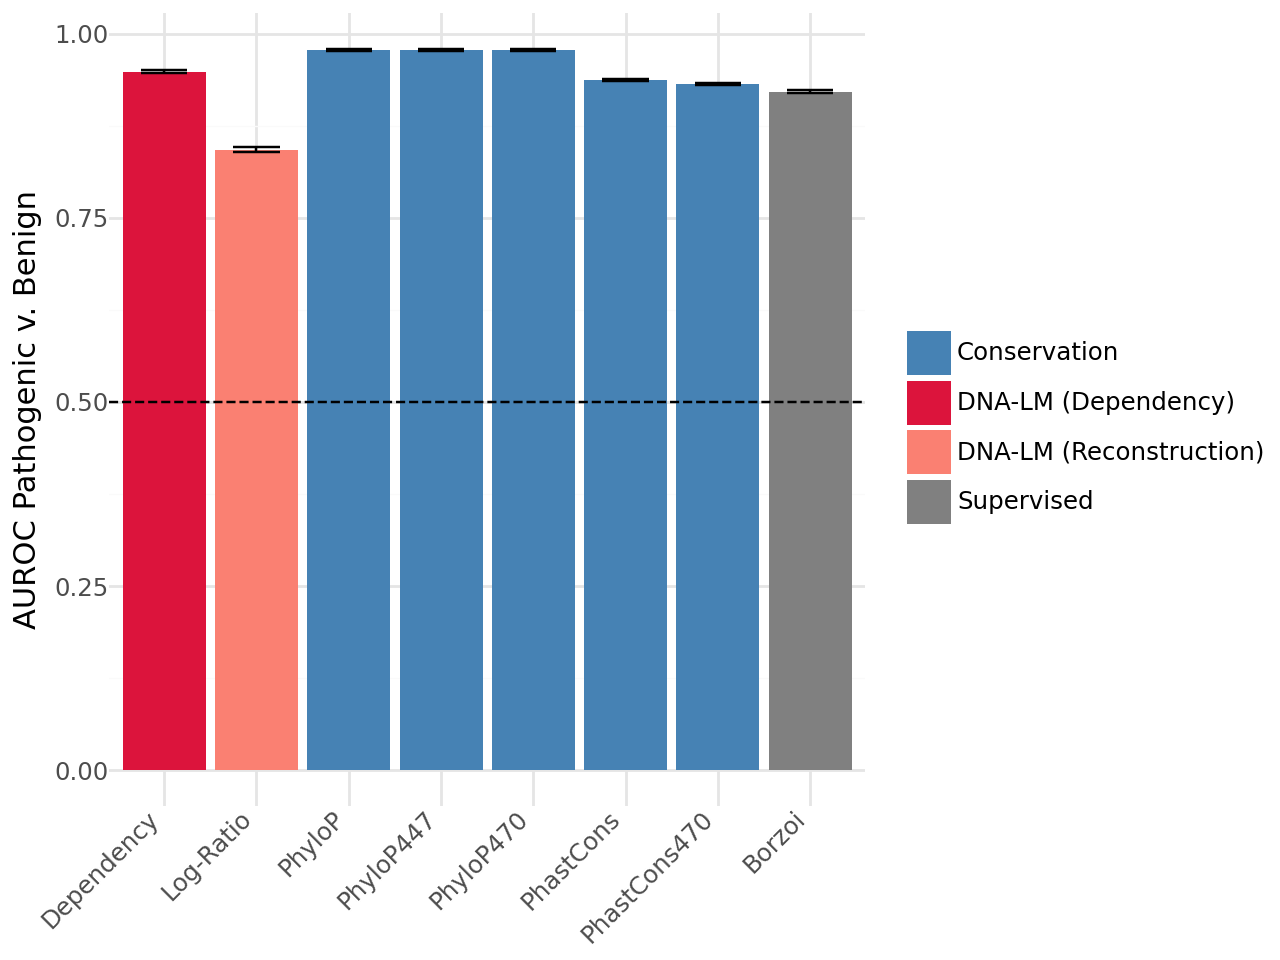

In [46]:
model_type_dict = {
    "Dependency":"DNA-LM (Dependency)",
    "Log-Ratio":"DNA-LM (Reconstruction)",
    "PhyloP":"Conservation",
    "PhyloP447":"Conservation",
    "PhyloP470":"Conservation",
    "PhastCons":"Conservation",
    "PhastCons470":"Conservation",
    'Borzoi':'Supervised',
}

plot_df = plot_rocs

plot_df["model_type"] = plot_df["variable"].apply(lambda x: model_type_dict[x])
plot_df["variable"] = pd.Categorical(plot_df["variable"],categories=model_type_dict.keys())


p = (p9.ggplot(data=plot_df, mapping=p9.aes(x="variable",y="value", fill="model_type")) 
 + p9.geom_bar(stat="identity")
 + p9.geom_errorbar(mapping=p9.aes(x="variable", ymin="auroc_min",ymax="auroc_max"))
 + p9.geom_hline(yintercept=0.5, linetype="dashed")
 + p9.scale_fill_manual(["steelblue","crimson","salmon", 'grey'])
 + p9.labs(x="",y="AUROC Pathogenic v. Benign", fill="")
 + p9.theme_minimal()
 + p9.theme(
     axis_text_x=p9.element_text(rotation=45, hjust=1),
 )
)


p

# Mutagenesis screen in 9 human Promoters

This dataset contains for each variant in a 2003 sequence containing a promoter, the value of the expression fold change for the corresponding affected gene. 
Assuming that the expression of each of these genes affects fitness in human, changes in the expression of the gene are a proxy for fitness effects.
Globally some genes might be more important for fitness than others. So while comparing fitness effects to changes in expression across genes might be misleading, if we condition on the same gene it should be ok.

The aim of this dataset is to evaluate how the metric you developed based on your model correlates with the expression fold change of the gene affected by the promoter variant

<<Important!!>> you do not need necessarily to extract any sequence around the variant, it is already provided in the benchmark.

In [6]:
kircher_path='/s/project/ml4rg_students/2025/project07/data/kircher_all_metrics_w_paper_w_gpn_msa_w_embs.tsv'

kircher_df = pd.read_csv(kircher_path, sep='\t')
kircher_df.loc[:, ['Chromosome', 'Start', 'End', 'five_prime_seq', 'var_rel_pos', 'Ref', 'Alt', 'ref']]

NameError: name 'pd' is not defined

Rename some columns

In [ ]:
kircher_df = kircher_df.rename(columns={"var_rel_pos": "Rel_pos", "five_prime_seq": "Seq"})
kircher_df.loc[:, ['Chromosome', 'Start', 'End', 'Seq', 'Rel_pos', 'Ref']]


,Chromosome,Start,End,Seq,Rel_pos,Ref
0,10,46046234,46046237,CTTAACTGCAAACAATAGAATTTACTCTAGGTCATTTGAGGTGGAA...,1498,C
1,10,46046234,46046237,CTTAACTGCAAACAATAGAATTTACTCTAGGTCATTTGAGGTGGAA...,1498,C
2,10,46046234,46046237,CTTAACTGCAAACAATAGAATTTACTCTAGGTCATTTGAGGTGGAA...,1498,C
3,10,46046234,46046237,CTTAACTGCAAACAATAGAATTTACTCTAGGTCATTTGAGGTGGAA...,1499,A
4,10,46046234,46046237,CTTAACTGCAAACAATAGAATTTACTCTAGGTCATTTGAGGTGGAA...,1499,A
...,...,...,...,...,...,...
8618,X,139530764,139530767,AGAAAAATTTTGCAATCTACTCATCTGTCCAAGGGCTAATACCTAG...,1998,T
8619,X,139530764,139530767,AGAAAAATTTTGCAATCTACTCATCTGTCCAAGGGCTAATACCTAG...,1998,T
8620,X,139530764,139530767,AGAAAAATTTTGCAATCTACTCATCTGTCCAAGGGCTAATACCTAG...,1999,T
8621,X,139530764,139530767,AGAAAAATTTTGCAATCTACTCATCTGTCCAAGGGCTAATACCTAG...,2000,A


In [ ]:
#five_prime_seq: -column with the 2003 sequence = five_prime_seq
#Start: column with the 2003 sequence start position in the genome
#End: column with the 2003 sequence end position in the genome
#Ref: column with the 2003 sequence reference allele in the same strand as the 2003 provided sequence
#ref: column with the 2003 sequence reference allele in the positive strand
#Alt: column with the 2003 sequence alternative allele in same strand as the 2003 provided sequence
#alt: column with the 2003 sequence alternative allele in the positive strand
#var_rel_pos: column with the relative position of the variant in the 2003 sequence

Load our model predictions and apply softmax

In [ ]:
loaded_preds = torch.load('kircher_predictions_regional.pt')
loaded_probs = F.softmax(loaded_preds, dim=-1)  # shape remains [B, 2003, 4]
print(loaded_probs.shape)

/scratch/tmp/s_gjamn/ipykernel_952412/3372229065.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


torch.Size([8623, 2003, 4])


In [ ]:
loaded_preds_pos = torch.load('kircher_predictions.pt')
loaded_probs_pos = F.softmax(loaded_preds_pos, dim=-1)  # shape remains [B, 2003, 4]
print(loaded_probs_pos.shape)

/scratch/tmp/s_gjamn/ipykernel_952412/3530854711.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


torch.Size([8623, 2003, 4])


### Correction for neutral model

In [ ]:
neutral_df = pd.read_csv('/s/project/ml4rg_students/2025/project07/group_2/data/merged.csv')
neutral_df

,Unnamed: 0.1,Unnamed: 0,sequence_context,total_count,var_count,var_freq,ref,alt,estimated_p_mutated
0,0,0,TATCGAT,354,30,0.084746,C,A,0.006495
1,1,1,TATCGAT,354,169,0.477401,C,T,0.085112
2,2,2,TATCGAT,354,41,0.115819,C,G,0.004966
3,3,3,CGATGGG,1225,237,0.193469,T,C,0.013260
4,4,4,CGATGGG,1225,62,0.050612,T,A,0.002437
...,...,...,...,...,...,...,...,...,...
49145,49145,49147,ACGAACG,294,16,0.054422,A,G,0.003210
49146,49146,49148,ACGAACG,294,6,0.020408,A,T,0.000977
49147,49147,49149,TCGAACG,238,4,0.016807,A,G,0.003399
49148,49148,49150,TCGAACG,238,2,0.008403,A,C,0.000944


In [ ]:
def nuc_pos_index(nucleotide):
    if nucleotide == 'A':
        one_hot = 0
    elif nucleotide == 'C':
        one_hot = 1
    elif nucleotide == 'G':
        one_hot = 2
    elif nucleotide == 'T':
        one_hot = 3
    else:
        raise ValueError(f"Unknown nucleotide {nucleotide} at position {i} in sequence {seq}")
    return one_hot

In [ ]:
import torch.nn.functional as F

def log_odds_correction(model_df, neutral_df, predictions, rel_pos=False):
    '''Gives the difference between the log(odds) for the polymorphism at a position from 
    the predictions of our model and the log(odds) for the polymorphism at a position in the
    neutral model. 
    inputs:
    - model_df: dataframe that has columns Seq, Rel_pos, Ref
    - neutral_df: neutral model dataframe
    - predictions: tensor of probabilities and shape [B, 2003, 4]
    - rel_pos: True/False, relative position of nucleotide in the sequence is known
    outputs:
    - alt_probs_sumes_list: list of all probabilities for polymorphism at a position
    - log_odds_list: list of computed log odds differences'''
    

    alt_probs_sumed_list = []
    log_odds_list = []
    not_matched = 0

    for idx, row in model_df.iterrows():

        sample_number = idx

        seq = row['Seq']
        ref = row['Ref']

        if rel_pos:
            pos = row['Rel_pos']
        else:
            pos = 1002

        # Get the predictions for our sample
        probs_sample = predictions[sample_number] #(2003, 4)

        # Get the prediction for our position in sequence
        probs_position = probs_sample[pos]

        # If the refrences align
        if ref == seq[pos]:

            # Positions for the 7-mer context
            start = pos - 3
            end = pos + 4
            seven_mer = seq[start:end]

            # Locate in the neutral model
            neutral_rows = neutral_df[neutral_df['sequence_context'] == seven_mer]

            # Sum of alternative probs - neutral model
            # TODO: change to correct value
            neutral_probs_sumed = neutral_rows['estimated_p_mutated'].sum()

            # Remove value for ref nucleotide in model predictions
            ref_index = nuc_pos_index(ref)
            mask = torch.arange(4) != ref_index
            probs_reduced = probs_position[mask]

            # Sum the alternative result
            model_probs_sumed = probs_reduced.sum()
            alt_probs_sumed_list.append(model_probs_sumed)

            # Odds
            epsilon = 1e-8
            odds_predicted = (model_probs_sumed + epsilon) / (1-model_probs_sumed + epsilon)
            odds_neutral = (neutral_probs_sumed + epsilon) / (1- neutral_probs_sumed + epsilon)

            # Optional: clip odds to avoid log(0) or log(very large)
            odds_predicted = np.clip(odds_predicted, epsilon, 1e8)
            odds_neutral = np.clip(odds_neutral, epsilon, 1e8)

            # Safe log-odds
            log_odds_final = np.log(odds_predicted) - np.log(odds_neutral)
            log_odds_list.append(log_odds_final.item())

        else:
            not_matched += 1

    print(f'Not matched: {not_matched}')

    return alt_probs_sumed_list, log_odds_list


In [ ]:
alt_p, log_odds = log_odds_correction(kircher_df, neutral_df, loaded_probs, rel_pos=True)

/scratch/tmp/s_gjamn/ipykernel_952412/2572659644.py:73: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)


Not matched: 0


In [ ]:
alt_p_pos, log_odds_pos = log_odds_correction(kircher_df, neutral_df, loaded_probs_pos, rel_pos=True)

/scratch/tmp/s_gjamn/ipykernel_952412/2572659644.py:73: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)


Not matched: 0


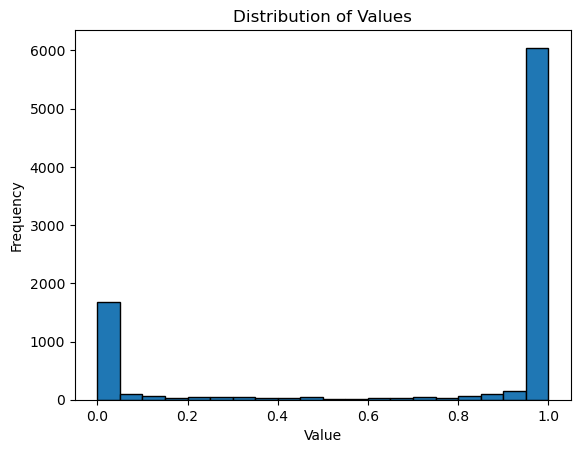

In [ ]:
# Plot histogram
plt.hist(alt_p_pos, bins=20, edgecolor='black')  # You can adjust 'bins' as needed
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Values')
plt.show()

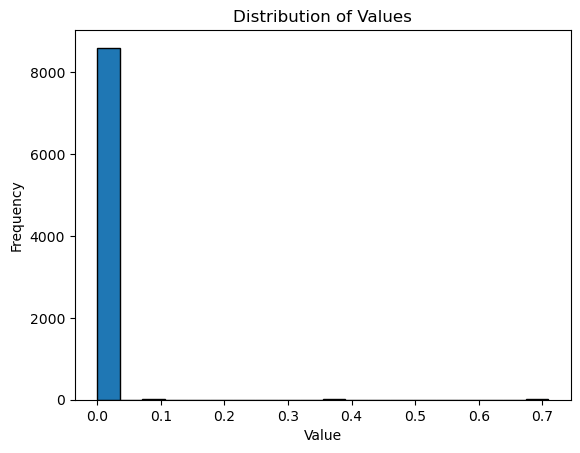

In [ ]:
# Plot histogram
plt.hist(alt_p, bins=20, edgecolor='black')  # You can adjust 'bins' as needed
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Values')
plt.show()

In [ ]:
log_odds

[19.41907501220703,
 19.41907501220703,
 19.41907501220703,
 12.497608184814453,
 12.497608184814453,
 12.497608184814453,
 -8.110007286071777,
 -8.110007286071777,
 20.85358238220215,
 20.85358238220215,
 20.85358238220215,
 2.1243553161621094,
 2.1243553161621094,
 15.33248519897461,
 15.33248519897461,
 20.918315887451172,
 20.918315887451172,
 20.918315887451172,
 15.091033935546875,
 15.091033935546875,
 15.091033935546875,
 23.26405906677246,
 23.26405906677246,
 23.26405906677246,
 10.46342658996582,
 10.46342658996582,
 10.46342658996582,
 22.46671485900879,
 22.46671485900879,
 22.46671485900879,
 12.16506576538086,
 12.16506576538086,
 -6.520883083343506,
 -6.520883083343506,
 20.498001098632812,
 20.498001098632812,
 21.546634674072266,
 21.546634674072266,
 21.546634674072266,
 22.613216400146484,
 22.613216400146484,
 22.613216400146484,
 20.053707122802734,
 20.053707122802734,
 20.053707122802734,
 15.722151756286621,
 15.722151756286621,
 15.722151756286621,
 23.2347183

In [ ]:
import pandas as pd
import torch

# Your full 3D tensor
big_tensor = torch.randn(100, 2003, 4)

# Split into a list of 2D tensors
tensor_list = [big_tensor[i] for i in range(big_tensor.shape[0])]


# Optionally add row IDs or labels
ids = [f"sample_{i}" for i in range(len(tensor_list))]

# Create the DataFrame
df = pd.DataFrame({
    "id": ids,
    "tensor": tensor_list
})

df.tensor[0].shape


torch.Size([2003, 4])

In [ ]:
df

,id,tensor
0,sample_0,"[[tensor(-1.0512), tensor(-1.6675), tensor(-0...."
1,sample_1,"[[tensor(-0.1002), tensor(-0.2427), tensor(-0...."
2,sample_2,"[[tensor(-1.4815), tensor(-0.2843), tensor(-0...."
3,sample_3,"[[tensor(-1.1408), tensor(-0.2568), tensor(-0...."
4,sample_4,"[[tensor(-1.2312), tensor(-0.7689), tensor(-1...."
...,...,...
95,sample_95,"[[tensor(0.4007), tensor(1.4247), tensor(-0.83..."
96,sample_96,"[[tensor(-0.7414), tensor(-0.8628), tensor(0.4..."
97,sample_97,"[[tensor(1.8396), tensor(0.3630), tensor(0.929..."
98,sample_98,"[[tensor(-1.1754), tensor(2.1880), tensor(0.69..."


In [ ]:
big_tensor.shape

torch.Size([100, 2003, 4])

In [ ]:
list(torch.cat(big_tensor).numpy())

TypeError: cat(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor

In [ ]:
import torch
import numpy as np
import ast
import re

# 1. Clean formatting: replace line breaks and make commas explicit if needed
s_clean = s.replace('\n', '').replace('  ', ' ').replace('   ', ' ').replace('    ', ' ')
print(s_clean)

rows = re.findall(r'\[([^\[\]]+)\]', s_clean)

# Step 2: Split each row into floats
list_of_lists = [list(map(float, row.strip().split())) for row in rows]

# Step 3: Convert to torch tensor (or numpy array if preferred)
tensor = torch.tensor(list_of_lists, dtype=torch.float32)

print(tensor)


[[ 0.68068504 -1.9831767  -3.4627142  0.54110235] [ -5.708281  -6.2301292  3.0277917  -1.6169574 ] [ -3.9484532  -5.811612 3.9328768  8.579103 ] ... [ -0.28481758  1.1236136 -14.82055 -2.026306 ] [ 3.0145202  -0.8650509  -6.1536264  5.112778 ] [ 2.4204783  2.693036  -3.8751206  -0.12923238]]
tensor([[  0.6807,  -1.9832,  -3.4627,   0.5411],
        [ -5.7083,  -6.2301,   3.0278,  -1.6170],
        [ -3.9485,  -5.8116,   3.9329,   8.5791],
        [ -0.2848,   1.1236, -14.8205,  -2.0263],
        [  3.0145,  -0.8651,  -6.1536,   5.1128],
        [  2.4205,   2.6930,  -3.8751,  -0.1292]])


In [ ]:
kircher_df['finetunedlog_odds'] = log_odds #fill in with your metric per variant get from the logits 

In [ ]:
from scipy.stats import pearsonr

columns = {
    "Log-Ratio": "Log-ratio\nSpeciesLM Metazoa",
    "gpn_msa_log_ratio": "GPN-MSA Log-Ratio",
    "Dependency": "Influence score\nSpeciesLM Metazoa",
    "finetunedlog_odds": "Finetuned Log Odds",
}
model_type_dict = {
    "Influence score\nSpeciesLM Metazoa": "DNA-LM (Dependency)",
    "Log-ratio\nSpeciesLM Metazoa": "DNA-LM (Reconstruction)",
    "GPN-MSA Log-Ratio": "Alignment-based DNA-LM\n(Reconstruction)",
    "phyloP": "Conservation",
    "phyloP447": "Conservation",
    "phyloP470": "Conservation",
    "PhastCons": "Conservation",
    "PhastCons470": "Conservation",
    "Finetuned Log Odds": "DNA LM Finetuned"

}

kircher_df.rename(columns=columns, inplace=True)
metrics = model_type_dict.keys()
metrics


dict_keys(['Influence score\nSpeciesLM Metazoa', 'Log-ratio\nSpeciesLM Metazoa', 'GPN-MSA Log-Ratio', 'phyloP', 'phyloP447', 'phyloP470', 'PhastCons', 'PhastCons470', 'Finetuned Log Odds'])

In [ ]:
real_cors_dict = {"locus": [], "metric": [], "r": []}

for metric in metrics:
    for locus in kircher_df["locus"].unique():

        locus_df = kircher_df[kircher_df["locus"] == locus].copy()
        real_r = pearsonr(np.abs(locus_df[metric]), np.abs(locus_df['abs_log2FC']))[0]
        
        real_cors_dict['locus'].append(locus)
        real_cors_dict['metric'].append(metric)
        real_cors_dict['r'].append(real_r)

real_cors_df = pd.DataFrame(real_cors_dict)
real_cors_df

,locus,metric,r
0,MSMB,Influence score\nSpeciesLM Metazoa,0.173442
1,HBB,Influence score\nSpeciesLM Metazoa,0.384668
2,HBG1,Influence score\nSpeciesLM Metazoa,0.532556
3,LDLR,Influence score\nSpeciesLM Metazoa,0.688417
4,PKLR,Influence score\nSpeciesLM Metazoa,0.388406
...,...,...,...
76,PKLR,Finetuned Log Odds,-0.032477
77,HNF4A,Finetuned Log Odds,-0.079737
78,GP1BB,Finetuned Log Odds,0.125758
79,TERT-GBM,Finetuned Log Odds,-0.062492


In [ ]:
#Average correlation per metric across promoters
summary_cors_real_mean_df = real_cors_df.groupby(["metric"])["r"].mean().reset_index()
summary_cors_real_mean_df

,metric,r
0,Finetuned Log Odds,-0.014907
1,GPN-MSA Log-Ratio,0.257294
2,Influence score\nSpeciesLM Metazoa,0.376619
3,Log-ratio\nSpeciesLM Metazoa,0.208531
4,PhastCons,0.269038
5,PhastCons470,0.257661
6,phyloP,0.172690
7,phyloP447,0.177925
8,phyloP470,0.186661


In [ ]:
from plotnine import *

#Here we do bootstrapping to estimate the variability of the correlations and get a confidence interval
n_samples = 20
correlations_list = []


for sample in range(n_samples):

    for locus in kircher_df["locus"].unique():

        locus_df = kircher_df[kircher_df["locus"] == locus].copy()
        locus_df = locus_df.sample(frac=1, replace=True).copy()

        correlations_dict = {"locus": [], "metric": [], "r": []}

        for metric in metrics:

            if metric in locus_df.columns:
                r = pearsonr(np.abs(locus_df[metric]), locus_df['abs_log2FC'])[0]
                correlations_dict['locus'].append(locus)
                correlations_dict['metric'].append(metric)
                correlations_dict['r'].append(r)
            else:
                print(f"Metric {metric} not found in locus {locus}. Skipping...")

        correlations_df = pd.DataFrame(correlations_dict)
        correlations_df["sample_id"] = f"{sample}"
        correlations_list.append(correlations_df)

correlations_df = pd.concat(correlations_list, axis=0)

summary_cors_2std_df = (
    correlations_df.groupby(["metric", "sample_id"])["r"]
    .mean()
    .reset_index()
    .groupby("metric")["r"]
    .std()
    * 2
).reset_index()

summary_cors_df = summary_cors_real_mean_df.merge(
    summary_cors_2std_df, on="metric", suffixes=("_mean", "_2std")
)

summary_cors_df["r_min"] = summary_cors_df["r_mean"] - summary_cors_df["r_2std"]
summary_cors_df["r_max"] = summary_cors_df["r_mean"] + summary_cors_df["r_2std"]

# MAKE PLOT
color_mapping = {
    "DNA-LM (Dependency)": "crimson",
    "DNA-LM (Reconstruction)": "salmon",
    "Alignment-based DNA-LM\n(Reconstruction)": "green",
    "Conservation": "steelblue"
    #"DNA-LM (Embedding)": "darkorange",
}

plot_df = summary_cors_df.copy()

plot_df["metric_type"] = plot_df["metric"].apply(lambda x: model_type_dict[x])
plot_df["metric"] = pd.Categorical(
    plot_df["metric"], categories=model_type_dict.keys()
)
plot_df["metric"] = pd.Categorical(
    plot_df["metric"],
    categories=list(
        plot_df.sort_values("r_mean", ascending=False)["metric"].values
    ),
    ordered=True,
)

p = (
    ggplot(
        data=plot_df, mapping=aes(x="metric", y="r_mean", fill="metric_type")
    )
    + geom_col()
    + geom_errorbar(mapping=aes(x="metric", ymin="r_min", ymax="r_max"))
    + scale_fill_manual(values=color_mapping)
    + labs(
        x="",
        y="Correlation with measured absolute\nvariant effects (mean over promoters)",
        fill="",
    )
    + theme_minimal()
    + theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(8, 6))
    + ylim(0, 0.44)
)
    


/opt/modules/i12g/anaconda/envs/ml4rg_p7_2/lib/python3.10/site-packages/plotnine/layer.py:344: PlotnineWarning: position_stack : Removed 1 rows containing missing values.
/opt/modules/i12g/anaconda/envs/ml4rg_p7_2/lib/python3.10/site-packages/plotnine/scales/scale_manual.py:39: PlotnineWarning: The palette of scale_fill_manual can return a maximum of 4 values. 5 were requested from it.
/opt/modules/i12g/anaconda/envs/ml4rg_p7_2/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_errorbar : Removed 1 rows containing missing values.
/opt/modules/i12g/anaconda/envs/ml4rg_p7_2/lib/python3.10/site-packages/plotnine/scales/scale_manual.py:39: PlotnineWarning: The palette of scale_fill_manual can return a maximum of 4 values. 5 were requested from it.


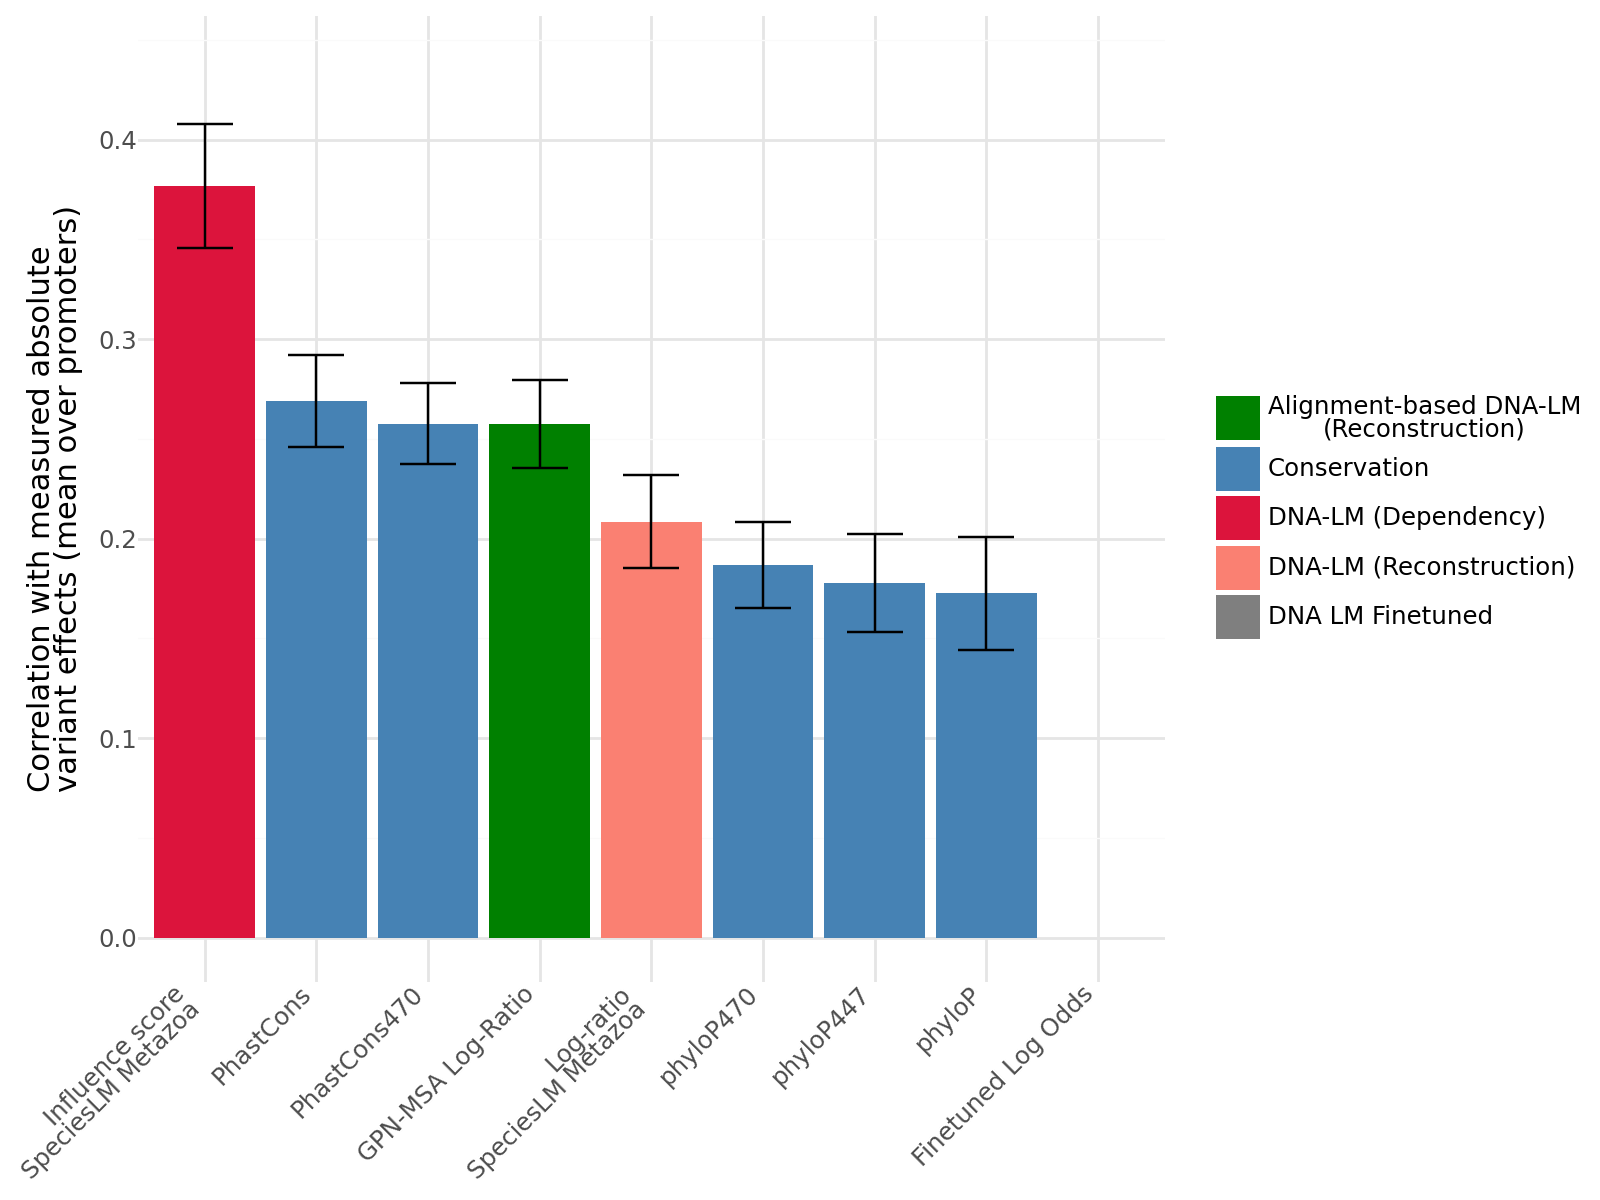

In [ ]:
p

# TraitGYM

In [1]:
trait_gym_vars_df = pd.read_csv('/s/project/ml4rg_students/2025/project07/data/trait_vars_w_seqs.csv')
trait_gym_vars_df

NameError: name 'pd' is not defined

In [ ]:
trait_gym_vars_df = trait_gym_vars_df.rename(columns={"seq": "Seq", "ref":"Ref"})

In [ ]:
preds_traitGYM = torch.load("trait_gym_vars.pt")

/scratch/tmp/s_gjamn/ipykernel_406192/2244256911.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [ ]:
alt_p, odds = log_odds_correction(trait_gym_vars_df, neutral_df, preds_traitGYM)

/scratch/tmp/s_gjamn/ipykernel_406192/3202630744.py:71: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)


Not matched: 0


This dataframe contains
- The position of the variant in 0-based coordinates!
- A label which tells whether the varinat was found causing a mendelian disease or not (True vs False) -> prediction target
- The consequence of that variant (ex. where it lies 5 UTR, upstream, intron, intergenic, etc.)

For this benchmark you should consider not including the variants that you used for training that overlap with the variants in this benchmark. That is becasue the negative set is defined by variants that are common in the population according to your training dataset (gnomad)

In [ ]:
# This computes the Area Under the precision recall curve weighted by the number of variants per chromosome.
# AUPRC by chrom

def benegas_scoring_auprc(df, metric):
    res_by_chrom = []
    for chrom in df.Chromosome.unique():
        V_chrom = df[df.Chromosome == chrom].copy()
        res_by_chrom.append([chrom, len(V_chrom), average_precision_score(V_chrom.label, V_chrom[metric])])
    res_by_chrom = pd.DataFrame(res_by_chrom, columns=["chrom", "n", "AUPRC"])
    res_by_chrom
    # Weighted average

    def stat(df):
        weight = df["n"] / df["n"].sum()
        return (df["AUPRC"] * weight).sum()

    return stat(res_by_chrom)

In [ ]:
benegas_scoring_auprc(trait_gym_vars_df, metric='your_developed_metric')

np.float64(0.537749320072972)

In [ ]:
previous_scores_df = pd.read_csv('/s/project/ml4rg_students/2025/project07/data/trait_gym_previous_scores.tsv', sep="\t")
previous_scores_df

,metric,AUPRC
0,SpeciesLM_llr,0.127138
1,SpeciesLM_influence_score,0.299355
2,GPN_MSA_llr,0.690183


In [ ]:
#append the new score as a row to the previous scores dataframe
new_score = pd.DataFrame({
    "metric": ["your_developed_metric"],
    "AUPRC": [benegas_scoring_auprc(trait_gym_vars_df, metric='your_developed_metric')]
})
previous_scores_df = pd.concat([previous_scores_df, new_score], ignore_index=True)

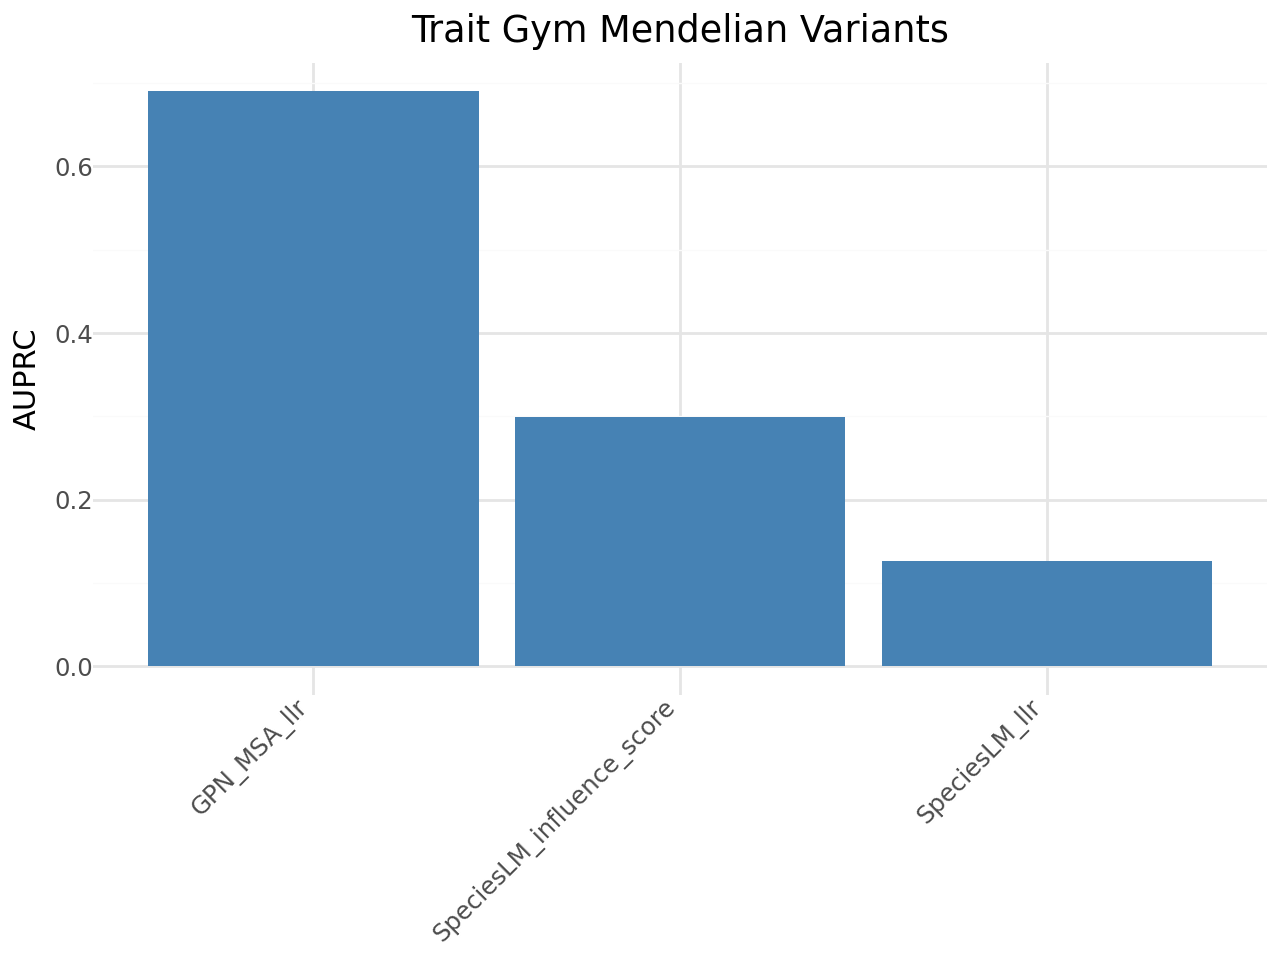

In [ ]:
#make a barplot with the previous scores
p = (
    p9.ggplot(data=previous_scores_df, mapping=p9.aes(x="metric", y="AUPRC"))
    + p9.geom_bar(stat="identity", fill="steelblue")
    + p9.labs(x="", y="AUPRC", title="Trait Gym Mendelian Variants")
    + p9.theme_minimal()
    + p9.theme(axis_text_x=p9.element_text(rotation=45, hjust=1))
)
p